In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## 1.1 Mathematical Derivation for GMM

#### Reference: _Christopher M. Bishop 2006, Pattern Recognition and Machine Learning_

Recall that the $\textbf{Gerneral EM Algorithm} $:

Given a joint distribution $p(X,Z\mid \theta)$ over observed variables $X$ and latent variables $Z$, governed by parameters $\theta$, the goal is to maximize the likelihood function $p(X\mid \theta )$ with respect to $\theta$.


1. Choose an initial setting for the parameters $\theta^{old}$.

2. $\textbf{E-Step} $ Evaluate $p(Z\mid X,\theta^{old})$.

3. $\textbf{M-Step} $ Evaluate $\theta^{new}$ given by 

$$\theta^{new}=arg\max_{\theta}\mathcal Q(\theta, \theta^{old})$$

where

$$\mathcal Q(\theta, \theta^{old}) = \sum_{Z}p(Z\mid X,\theta^{old})\ln p(X,Z\mid \theta)=\mathbb E_{Z\mid X,\theta^{old}} \Big[\ln p(X,Z\mid \mu,\theta)\Big]$$

4. Check for convergence of either the log likelihood or the parameter values. If the convergence criterion is not satisfied, then let $\theta^{old}\gets \theta^{new}$ and return to step 2.

Now, for GMM case, we should have 

\begin{align*}
	p(X,Z\mid \mu,\Sigma,\pi) &= \prod_{n=1}^{N}\prod_{k=1}^{K} \pi_{k}^{z_{nk}} \mathcal N(x_{n}\mid \mu_{k},\Sigma_{k})^{z_{nk}}\\
	\ln p(X,Z\mid \mu,\Sigma,\pi) &= \sum_{n=1}^{N}\sum_{k=1}^{K} z_{nk} \Big[\ln \pi_{k} + \ln \mathcal N(x_{n}\mid \mu_{k},\Sigma_{k})\Big]
\end{align*}

and

\begin{align*}
	p(Z\mid X,\mu,\Sigma,\pi) &\propto \prod_{n=1}^{N}\prod_{k=1}^{K}\Big[\pi_{k}\mathcal N(x_{n}\mid \mu_{k},\Sigma_{k})\Big]^{z_{nk}}\\
	\mathbb E[z_{nk}] &= \frac{\sum_{z_{nk}}z_{nk}\Big[\pi_{k}\mathcal N(x_{n}\mid \mu_{k},\Sigma_{k})\Big]^{z_{nk}}}{\sum_{z_{nj}}\Big[\pi_{j}\mathcal N(x_{n}\mid \mu_{j},\Sigma_{j})\Big]^{z_{nj}}}= \frac{\pi_{k}\mathcal N(x_{n}\mid \mu_{k},\Sigma_{k})}{\sum_{j=1}^{K}\pi_{j}\mathcal N(x_{n}\mid \mu_{j},\Sigma_{j})}
\end{align*}

Therefore, we have the $\textbf{EM for GMM} $:

1. Initialize the means $\mu_{k}$, covariances $\Sigma_{k}$ and mixing coefficients $\pi_{k}$, and evaluate the initial value of the log likelihood.

2. $\textbf{E-Step} $ Evaluate the responsibilities using the current parameter values

\begin{align*}
	\gamma(z_{nk}) = \mathbb E[z_{nk}] = \frac{\sum_{z_{nk}}z_{nk}\Big[\pi_{k}\mathcal N(x_{n}\mid \mu_{k},\Sigma_{k})\Big]^{z_{nk}}}{\sum_{z_{nj}}\Big[\pi_{j}\mathcal N(x_{n}\mid \mu_{j},\Sigma_{j})\Big]^{z_{nj}}}= \frac{\pi_{k}\mathcal N(x_{n}\mid \mu_{k},\Sigma_{k})}{\sum_{j=1}^{K}\pi_{j}\mathcal N(x_{n}\mid \mu_{j},\Sigma_{j})}
\end{align*}

3. $\textbf{M-Step} $ Re-estimate the parameters using the current responsibilities

\begin{align*}
	\mu_{k}^{new} &= \frac{1}{N_{k}} \sum_{n=1}^{N} \gamma(z_{nk})x_{n}\\
	\Sigma_{k}^{new} &= \frac{1}{N_{k}} \sum_{n=1}^{N} \gamma(z_{nk})(x_{n}-\mu_{k}^{new})(x_{n}-\mu_{k}^{new})^{T}\\
	\pi_{k}^{new} &= \frac{N_{k}}{N}
\end{align*}

where

\begin{align*}
	N_{k} = \sum_{n=1}^{N} \gamma(z_{nk})
\end{align*}

4. Evaluate the log likelihood

\begin{align*}
	\ln p(X\mid \mu,\Sigma,\pi) = \sum_{n=1}^{N} \ln\left (\sum_{k=1}^{K} \pi_{k}\mathcal N(x_{n}\mid \mu_{k},\Sigma_{k})\right )
\end{align*}

and check for convergence of either the parameters or the log likelihood. If the convergence criterion is not satisfied return to step 2.

## 1.2 Implementation

In [2]:
from scipy.stats import multivariate_normal as mvn
from sklearn.cluster import KMeans

class GMM:
    def __init__(self, C, D=2, max_iter=100):
        
        # Basic values
        self.C = C          # number of Guassians/clusters
        self.D = D          # data dimension
        self.N = None       # number of data points, will be initialized in _paramInit
        self.X = None       # data points, will be initialized in _paramInit
        self.max_iter = max_iter
        
        # Parameters for GMM
        self.pi = np.zeros(self.C)
        self.mu = np.zeros((self.C, self.D))
        self.sigma = np.zeros((self.C, self.D, self.D))
        self.gamma = None   # should have size N x C, will be initialized in _paramInit
        self.loss = 0.0
        
    def fit(self, X):
        """
        Repeat Step 1 - Step 4 as mentioned in 1.1
        Inputs:
            X: Training data of size N x D
        """
        self._paramInit(X)
        
        for run in range(self.max_iter):
            self._eStep()
            self._mStep()
            loss = self._loss()
            print("Iteration: %d Loss: %0.10f" %(run, loss))
            
            # test for convergence
            if abs(self.loss - loss) < 1e-12:
                break
            else:
                self.loss = loss   
    
    def predict(self, X):
        """
        Returns predicted labels using Bayes Rule to Calculate the posterior distribution
        Inputs:
            X: Test data of size N' x d       
        Outputs:
            labels: predicted cluster
            probs : probability of this cluster
        """
        probs = np.zeros((X.shape[0], self.C))
        
        for c in range(self.C):
            probs[:,c] = self.pi[c] * mvn.pdf(X, self.mu[c,:], self.sigma[c])
        probs /= np.sum(probs, axis=1).reshape(-1,1)
        
        return probs.argmax(1), probs.max(1)
    
    def _paramInit(self, X):
        """
        Calculate initial pi, mu and sigma of different clusters from k-means predictions
        
        Inputs:
            X: Data points of size N x D
        
        Outputs:
            Initial values for  pi, mu and sigma
        """
        # initialize the rest parameters
        self.X = X
        self.N = X.shape[0]        
        self.gamma = np.zeros((self.N, self.C))
        
        # get init labels by kMean
        kmeans = KMeans(n_clusters=self.C, init="k-means++", max_iter=100, algorithm = 'auto')
        fitted = kmeans.fit(X)
        y = kmeans.predict(X)

        # init GMM parameters by kMean labels
        # reference: https://datascience.stackexchange.com/questions/11487/how-do-i-obtain-the-weight-and-variance-of-a-k-means-cluster
        labels = np.unique(y)
        for ind, label in enumerate(labels):
            ids = np.where(y == label)  # returns indices
            self.pi[ind] = len(ids[0]) / X.shape[0]
            self.mu[ind,:] = np.mean(X[ids], axis = 0)
            de_meaned = X[ids] - self.mu[ind,:]
            n = X[ids].shape[0]         # number of data points in current gaussian
            self.sigma[ind,:, :] = np.dot(self.pi[ind] * de_meaned.T, de_meaned) / n
        assert np.sum(self.pi) == 1
            
    def _eStep(self):
        """
        Performs E-step on GMM model
        """


        for c in range(self.C):
            # Posterior Distribution using Bayes Rule
            self.gamma[:,c] = self.pi[c] * mvn.pdf(self.X, self.mu[c,:], self.sigma[c])

        # normalize across columns to make a valid probability
        self.gamma /= np.sum(self.gamma, axis=1).reshape(-1,1)
    
    
    def _mStep(self):
        """
        Performs M-step of the GMM
        """
        Nk = np.sum(self.gamma, axis = 0).reshape(-1,1)
        # responsibilities for each gaussian
        self.pi = np.mean(self.gamma, axis = 0)
        self.mu = np.dot(self.gamma.T, self.X) / Nk

        for c in range(self.C):
            x = self.X - self.mu[c, :]
            gamma_diag = np.diag(self.gamma[:,c])
            sigma_c = x.T @ gamma_diag @ x
            self.sigma[c,:,:]=(sigma_c) / Nk[c]
    
    
    def _loss(self):
        """
        Computes log likelihood
        """
        loss = np.zeros(self.N)
        for p, m, s in zip(self.pi, self.mu, self.sigma):
            loss += p * mvn.pdf(self.X, m, s)
        loss = np.log(loss).sum()

        return loss

## 1.3 Some data failed for kMean

In [3]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4, cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

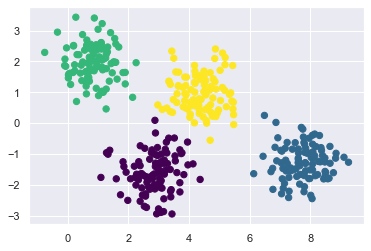

In [4]:
# KMean works fine for strandard data
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

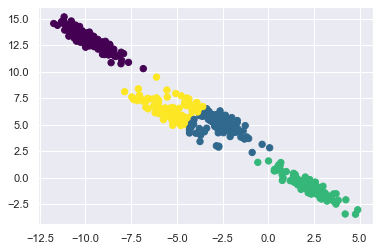

In [5]:
# but failed to work for stretched data
X_stretched = np.dot(X, np.array([[-1,1.5],[1.5,-1]]))
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X_stretched).predict(X_stretched)
plt.scatter(X_stretched[:, 0], X_stretched[:, 1], c=labels, s=40, cmap='viridis');

## 1.4 Test on GMM

In [6]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

In [7]:
model = GMM(C=4)
model.fit(X_stretched)
labels, probs = model.predict(X_stretched)

Iteration: 0 Loss: -1409.1982784797
Iteration: 1 Loss: -1404.6226609246
Iteration: 2 Loss: -1401.3910174078
Iteration: 3 Loss: -1396.5057828571
Iteration: 4 Loss: -1386.3859293485
Iteration: 5 Loss: -1374.3940498291
Iteration: 6 Loss: -1364.7272954526
Iteration: 7 Loss: -1357.3125638770
Iteration: 8 Loss: -1354.7051832286
Iteration: 9 Loss: -1354.2212246076
Iteration: 10 Loss: -1354.1376031440
Iteration: 11 Loss: -1354.1210496810
Iteration: 12 Loss: -1354.1175936927
Iteration: 13 Loss: -1354.1168587886
Iteration: 14 Loss: -1354.1167012997
Iteration: 15 Loss: -1354.1166674313
Iteration: 16 Loss: -1354.1166601361
Iteration: 17 Loss: -1354.1166585635
Iteration: 18 Loss: -1354.1166582244
Iteration: 19 Loss: -1354.1166581513
Iteration: 20 Loss: -1354.1166581355
Iteration: 21 Loss: -1354.1166581321
Iteration: 22 Loss: -1354.1166581314
Iteration: 23 Loss: -1354.1166581312
Iteration: 24 Loss: -1354.1166581312
Iteration: 25 Loss: -1354.1166581312
Iteration: 26 Loss: -1354.1166581312
Iteration: 

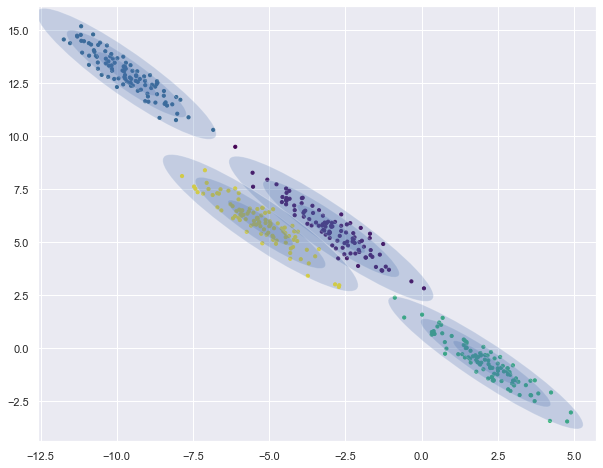

In [8]:
plt.figure(figsize = (10,8))
plt.scatter(X_stretched[:, 0], X_stretched[:, 1],c=labels, s=10, cmap='viridis')

w_factor = 0.2 / model.pi.max()
for pos, covar, w in zip(model.mu, model.sigma, model.pi):
    draw_ellipse(pos, covar, alpha = w)

## 1.5 Test on wrong componenets

### 1.5.1 `C=5`

In [9]:
model = GMM(C=5)
model.fit(X_stretched)
labels, probs = model.predict(X_stretched)

Iteration: 0 Loss: -1415.5871306436
Iteration: 1 Loss: -1407.1121692144
Iteration: 2 Loss: -1402.7492184400
Iteration: 3 Loss: -1397.4725622267
Iteration: 4 Loss: -1387.3324555178
Iteration: 5 Loss: -1375.5164199521
Iteration: 6 Loss: -1365.9319485890
Iteration: 7 Loss: -1358.0743945605
Iteration: 8 Loss: -1354.9591444435
Iteration: 9 Loss: -1354.3017071443
Iteration: 10 Loss: -1354.1581256599
Iteration: 11 Loss: -1354.1054626181
Iteration: 12 Loss: -1354.0739407946
Iteration: 13 Loss: -1354.0492703845
Iteration: 14 Loss: -1354.0276615889
Iteration: 15 Loss: -1354.0076074163
Iteration: 16 Loss: -1353.9881577262
Iteration: 17 Loss: -1353.9684917831
Iteration: 18 Loss: -1353.9477618617
Iteration: 19 Loss: -1353.9249889938
Iteration: 20 Loss: -1353.8989611502
Iteration: 21 Loss: -1353.8681300053
Iteration: 22 Loss: -1353.8305380027
Iteration: 23 Loss: -1353.7838680679
Iteration: 24 Loss: -1353.7257976107
Iteration: 25 Loss: -1353.6548805690
Iteration: 26 Loss: -1353.5719536016
Iteration: 

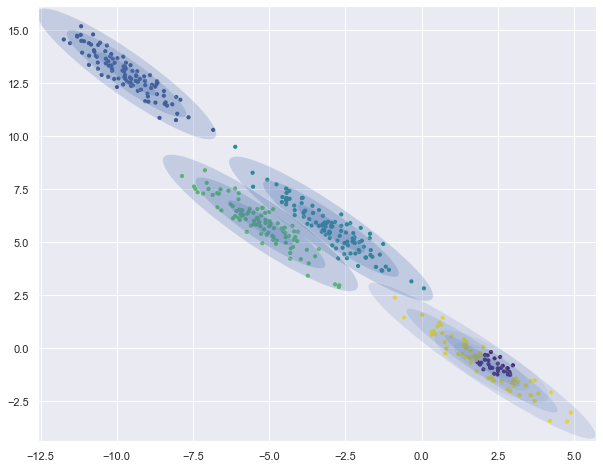

In [10]:
plt.figure(figsize = (10,8))
plt.scatter(X_stretched[:, 0], X_stretched[:, 1],c=labels, s=10, cmap='viridis')

w_factor = 0.2 / model.pi.max()
for pos, covar, w in zip(model.mu, model.sigma, model.pi):
    draw_ellipse(pos, covar, alpha = w)

### 1.5.2 `C=3`

In [11]:
model = GMM(C=3)
model.fit(X_stretched)
labels, probs = model.predict(X_stretched)

Iteration: 0 Loss: -1410.7520370611
Iteration: 1 Loss: -1410.3192945205
Iteration: 2 Loss: -1410.2712394934
Iteration: 3 Loss: -1410.2670953037
Iteration: 4 Loss: -1410.2667865098
Iteration: 5 Loss: -1410.2667645715
Iteration: 6 Loss: -1410.2667630333
Iteration: 7 Loss: -1410.2667629258
Iteration: 8 Loss: -1410.2667629183
Iteration: 9 Loss: -1410.2667629178
Iteration: 10 Loss: -1410.2667629177
Iteration: 11 Loss: -1410.2667629177
Iteration: 12 Loss: -1410.2667629177


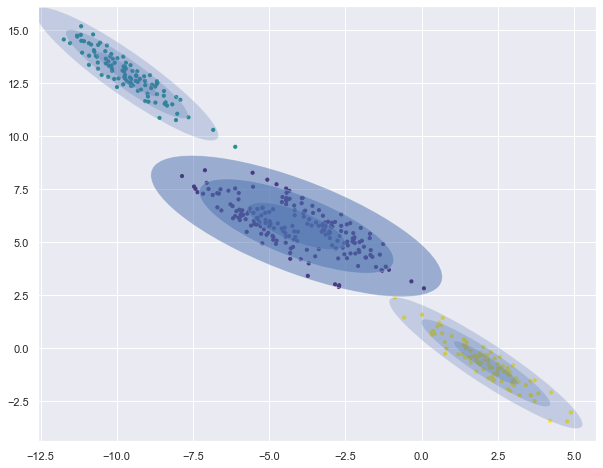

In [12]:
plt.figure(figsize = (10,8))
plt.scatter(X_stretched[:, 0], X_stretched[:, 1],c=labels, s=10, cmap='viridis')

w_factor = 0.2 / model.pi.max()
for pos, covar, w in zip(model.mu, model.sigma, model.pi):
    draw_ellipse(pos, covar, alpha = w)